In [22]:
using NCDatasets
using Oceananigans
using CairoMakie

In [3]:
using Interpolations
using NaNStatistics

In [5]:
ds = NCDataset(string("/pub/ikeshwan/code/HorizontalConvection/output/turbulent_h0.3_buoyancy.nc"))
x = ds["xC"][4+1:end-4]; Nx = length(x);
y = ds["yC"][4+1:end-4]; Ny = length(y);
z = ds["zC"][4+1:end-4]; Nz = length(z);

256

In [6]:
Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
Δy = reshape(diff(ds["yF"])[4+1:end-3], 1,Ny,1); # periodic in y so just left positions
Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);

ΔA = Δx.*Δy;
ΔV = ΔA.*Δz;

In [8]:
function calc_zstar(b)
    
    wet = b.!=0.;
    b[.!wet] .= NaN;
    
    z_3d = repeat(reshape(z, 1,1,Nz), Nx, Ny, 1);
    b_flat = reshape(b, (Nx*Ny*Nz));
    wet_flat = reshape(wet, (Nx*Ny*Nz));
    z_flat = reshape(z_3d, (Nx*Ny*Nz));
    
    sort_idx = sortperm(b_flat);
    b_sorted, z_sorted = b_flat[sort_idx], z_flat[sort_idx];
    
    ΔV_flat = ΔV[sort_idx];
    
    A_wet = dropdims(sum(wet.*ΔA, dims=(1,2)), dims=(1,2));
    A_interpolation = linear_interpolation(z, A_wet, extrapolation_bc=Line());
    
    z_bot = ds["zF"][5] # ignore 4 halo points
    zstar_flat = zeros(size(b_sorted))
    zstar_flat[1] = z_bot
    for k in 2:length(b_sorted)
        A = A_interpolation(zstar_flat[k-1])
        if !isnan(b_sorted[k])
            zstar_flat[k] = zstar_flat[k-1] + ΔV_flat[k]/A
        else
            zstar_flat[k] = NaN
        end
    end
    
    unsort_idx = sortperm(sort_idx)
    zstar = reshape(zstar_flat[unsort_idx], size(b))

    return zstar
end

calc_zstar (generic function with 1 method)

In [13]:
t = (ds["time"])

time (2)
  Datatype:    Float64 (Float64)
  Dimensions:  time
  Attributes:
   units                = seconds
   long_name            = Time


In [19]:
#want to index b the same way x,y,z were to ignore the halos
#this will be a time snapshot of b at t=10 seconds

b = ds["b"][4+1:end-4, 4+1:end-4, 4+1:end-4, 2];

In [20]:
wet = b.!=0.; # This does not work for the initial timestep because our initial condition is that b==0 everywhere!

b[.!wet] .= NaN;

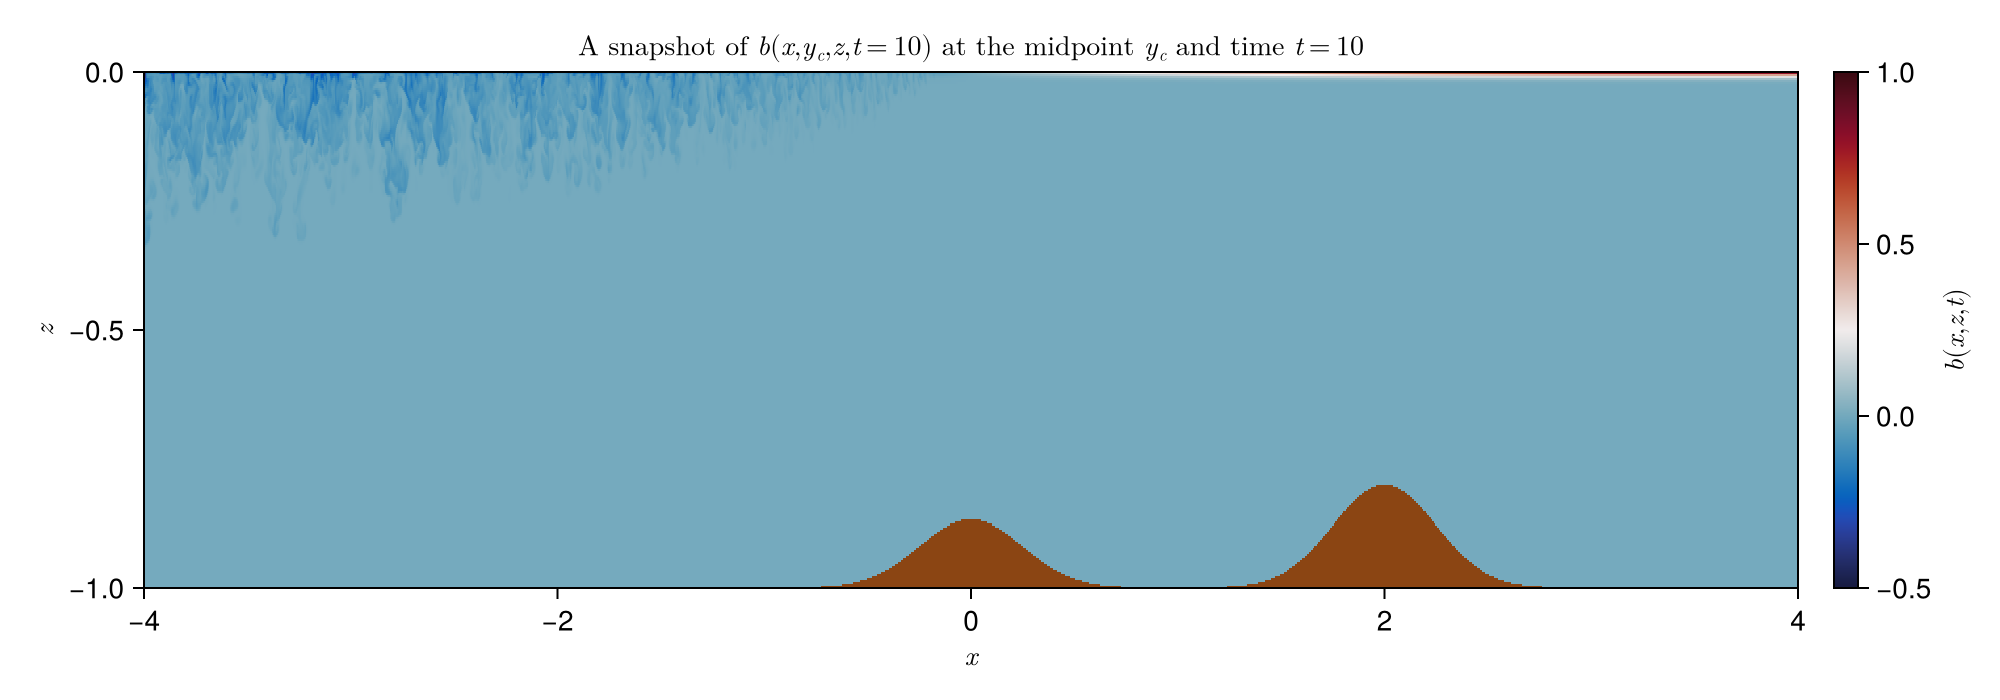

In [25]:
f = Figure(size=(1000,350))
ax = Axis(f[1,1], xlabel= L"$x$", ylabel = L"$z$", title=L"A snapshot of $b(x,y_{c}, z, t=10)$ at the midpoint $y_c$ and time $t=10$")
nan_color = :brown
hm = heatmap!(ax, x, z, b[:,Ny÷2,:], colorrange = (-0.5, 1.0), colormap = :balance, nan_color=:chocolate4)
Colorbar(f[1,2], hm, label=L"$b(x,z,t)$");

f